In [1]:
import logging
import sys
from pathlib import Path


logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s: %(message)s",
    force=True,
)

# Add the src directory to the Python path
sys.path.append(str(Path.cwd().parent.parent))

In [2]:
from src.nas.mlp_chromosome import RawMLPChromosome


low, high = RawMLPChromosome.get_bounds()
low, high

(array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([7, 3, 8, 7, 8, 7, 8, 7, 2, 3, 3, 1, 1, 6, 3]))

In [3]:
from src.nas.mlp_nas_problem import MlpNasProblem
from src.nas.nas import NasParams
from src.datasets.vertebral_dataset import VertebralDataset
from src.datasets.breast_cancer_dataset import BreastCancerDataset
from src.nas.plot import hist_accuracies


DatasetClass = VertebralDataset
params = NasParams(
    epochs=10,
    patience=5,
    amount_of_evaluations=1,
    population_size=10,
    population_offspring_count=4,
    algorithm_generations=1,
    # population_store_file=DatasetClass.__name__ + "_population.csv",
)
problem = MlpNasProblem(params, DatasetClass)

problem.get_min_complexity(), problem.get_max_complexity()

INFO: Loading cached vertebral from /home/nur/Projects/vut-ip1-nn-quantization/datasets_cache/vertebral_cache.pkl
INFO: Loading cached breast_cancer from /home/nur/Projects/vut-ip1-nn-quantization/datasets_cache/breast_cancer_cache.pkl


(162.0, np.float64(2160.0))

In [4]:
plow = problem.get_nn_params(RawMLPChromosome(low).parse())
phigh = problem.get_nn_params(RawMLPChromosome(high).parse())

problem.compute_nn_complexity(plow), problem.compute_nn_complexity(phigh)

(162.0, np.float64(2160.0))

In [5]:
from pymoo.optimize import minimize

from src.constants import SEED


algorithm = params.get_algorithm()
termination = params.get_termination()

res = minimize(problem, algorithm, verbose=True, seed=SEED, termination=termination)

if params.population_store_file is not None:
    params.store_population(res, params.population_store_file)

print(f"Solutions: {res.X}")
print(f"Objectives: {res.F}")

INFO: No population file provided. Using random sampling


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       10 |      3 |             - |             -
Solutions: [[4 0 3 7 2 0 4 4 1 0 3 0 0 5 3]
 [7 1 4 1 8 5 6 4 2 1 3 0 1 5 1]
 [0 0 7 6 1 0 1 2 2 0 0 1 0 4 2]]
Objectives: [[-0.70967742  0.10718336  0.03571429]
 [-0.58064516  0.07027027  0.21428571]
 [-0.29032258  0.          0.        ]]


In [6]:
df = problem.result_as_df(res)
df

,Accuracy,Complexity,fc,train,Chromosome
0,70.967742,376.152351,"{'layers': [{'height': 6, 'weight_qmode': Weig...","{'train_loader': ([tensor([[ 63.7724, 12.7634...","[4, 0, 3, 7, 2, 0, 4, 4, 1, 0, 3, 0, 0, 5, 3]"
1,58.064516,302.400000,"{'layers': [{'height': 6, 'weight_qmode': Weig...","{'train_loader': ([tensor([[ 54.9194, 21.0623...","[7, 1, 4, 1, 8, 5, 6, 4, 2, 1, 3, 0, 1, 5, 1]"
2,29.032258,162.000000,"{'layers': [{'height': 6, 'weight_qmode': Weig...","{'train_loader': ([tensor([[ 52.8622, 9.4104...","[0, 0, 7, 6, 1, 0, 1, 2, 2, 0, 0, 1, 0, 4, 2]"


In [7]:
from pprint import pprint

ch = RawMLPChromosome(df.loc[0]["Chromosome"]).parse()
params = problem.get_nn_params(ch)
pprint(params)

MLPParams(fc=FCParams(layers=[FCLayerParams(height=6,
                                            weight_qmode=<WeightQuantMode.NBITS: 'nbits'>,
                                            weight_bitwidth=5),
                              FCLayerParams(height=3,
                                            weight_qmode=<WeightQuantMode.NONE: 'none'>,
                                            weight_bitwidth=32)],
                      activation=ActivationParams(activation=<ActivationModule.RELU: 'relu'>,
                                                  binary_qmode=<QMode.DET: 'det'>,
                                                  reste_o=4.0,
                                                  reste_threshold=1.5),
                      qmode=<QMode.DET: 'det'>,
                      dropout_rate=0.1),
          train=NNTrainParams(train_loader=<torch.utils.data.dataloader.DataLoader object at 0x7acebd6552b0>,
                              test_loader=<torch.utils.data.dataloader.

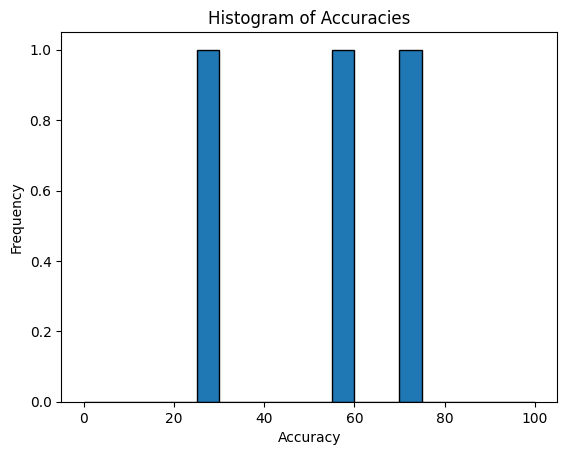

In [8]:
fig = hist_accuracies(df["Accuracy"])

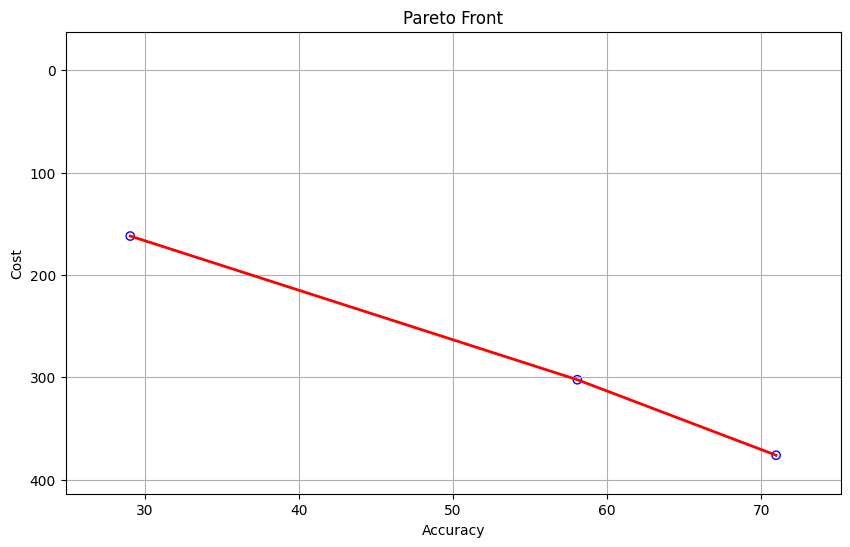

In [9]:
from src.nas import plot

plot.plot_pareto_front(df["Accuracy"], df["Complexity"])

In [10]:
from src.nas.cnn_chromosome import CNNChromosome, RawCNNChromosome


RawCNNChromosome.get_bounds()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0]),
 array([7, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 7, 3, 7, 3, 7, 2, 3, 3, 1,
        1, 6, 3]))

In [11]:
RawCNNChromosome.get_size()

25

In [12]:
from src.datasets.mnist_dataset import MiniMNISTDataset
from src.nas.cnn_nas_problem import CnnNasProblem


CnnDatasetClass = MiniMNISTDataset
cnn_nas_params = NasParams(
    epochs=1,
    patience=5,
    amount_of_evaluations=1,
    population_size=20,
    population_offspring_count=8,
    algorithm_generations=1,
    population_store_file=CnnDatasetClass.__name__ + "_population.csv",
)
cnn_problem = CnnNasProblem(cnn_nas_params, CnnDatasetClass)

cnn_problem.get_min_complexity(), cnn_problem.get_max_complexity()

(229672.0, 1454520.0)

In [13]:
from src.models.cnn import CNN, CNNEvaluator

x = [7, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
cnn_ch = RawCNNChromosome(x).parse()
pprint(cnn_ch)

cnn_params = cnn_problem.get_nn_params(cnn_ch)
CNN(cnn_params)

CNNChromosome(in_bitwidth=8,
              conv_layers=2,
              conv_channels1=16,
              conv_stride1=1,
              conv_pooling_size1=1,
              conv_channels2=32,
              conv_stride2=1,
              conv_pooling_size2=2,
              conv_channels3=16,
              conv_stride3=1,
              conv_pooling_size3=1,
              fc_layers=3,
              fc_height1=32,
              fc_bitwidth1=1,
              fc_height2=32,
              fc_bitwidth2=1,
              fc_height3=32,
              fc_bitwidth3=1,
              dropout=0.0,
              activation=<ActivationModule.RELU: 'relu'>,
              reste_o=1.5,
              quatization_mode=<QMode.DET: 'det'>,
              binarization_mode=<QMode.DET: 'det'>,
              learning_rate=0.0001,
              weight_decay=0.01)


CNN(
  (in_quantize_layer): Module_Quantize()
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2dWrapper(1, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2dWrapper(16, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fc_layers): Sequential(
    (0): QuantizedWeightLinear(in_features=4608, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): QuantizedWeightLinear(in_features=32, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): QuantizedWeightLinear(in_featu

In [14]:
CNNEvaluator(cnn_params).evaluate_model()

{'max': 10.125, 'mean': np.float64(10.125), 'std': np.float64(0.0)}

In [15]:
from pprint import pprint


x = RawCNNChromosome.get_bounds()[0]
x[0] = 7
x[1] = 1
x[2] = 2
x[7] = 1
ch = RawCNNChromosome(x).parse()
pprint(ch)

x

CNNChromosome(in_bitwidth=8,
              conv_layers=2,
              conv_channels1=32,
              conv_stride1=1,
              conv_pooling_size1=1,
              conv_channels2=16,
              conv_stride2=1,
              conv_pooling_size2=2,
              conv_channels3=16,
              conv_stride3=1,
              conv_pooling_size3=1,
              fc_layers=1,
              fc_height1=32,
              fc_bitwidth1=1,
              fc_height2=32,
              fc_bitwidth2=1,
              fc_height3=32,
              fc_bitwidth3=1,
              dropout=0.0,
              activation=<ActivationModule.RELU: 'relu'>,
              reste_o=1.5,
              quatization_mode=<QMode.DET: 'det'>,
              binarization_mode=<QMode.DET: 'det'>,
              learning_rate=0.0001,
              weight_decay=0.01)


array([7, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0])

In [16]:
from pymoo.optimize import minimize

from src.constants import SEED


algorithm = cnn_nas_params.get_algorithm()
termination = cnn_nas_params.get_termination()

res = minimize(cnn_problem, algorithm, verbose=True, seed=SEED, termination=termination)

if cnn_nas_params.population_store_file is not None:
    cnn_nas_params.store_population(res, cnn_nas_params.population_store_file)

print(f"Solutions: {res.X}")
print(f"Objectives: {res.F}")

INFO: Population file loaded successfully


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |        4 |      3 |             - |             -
Solutions: [[3 1 1 0 1 0 1 1 2 0 1 0 2 2 2 1 1 0 2 0 3 1 1 2 3]
 [0 0 0 0 1 2 1 1 0 1 1 0 2 1 1 0 3 6 0 3 3 1 0 6 0]
 [0 2 2 1 1 1 0 0 2 0 0 2 2 2 2 3 1 7 0 0 0 0 0 5 3]]
Objectives: [[-0.4175      0.          0.10714286]
 [-0.44375     0.32382271  0.        ]
 [-0.7925      0.          0.42857143]]


In [17]:
df = cnn_problem.result_as_df(res)
df

,Accuracy,Complexity,conv_in_channels,conv_in_dimensions,conv_in_bitwidth,conv_out_height,conv_layers,conv_activation,conv_qmode,conv_dropout_rate,fc_layers,fc_activation,fc_qmode,fc_dropout_rate,train_epochs,train_learning_rate,train_weight_decay,train_early_stop_patience,Chromosome
0,41.750,229672.0,1,28,4,10,"[{'channels': 24, 'kernel_size': 3, 'stride': ...",ActivationModule.RELU,QMode.STOCH,0.2,"[{'height': 784, 'weight_qmode': WeightQuantMo...","{'activation': ActivationModule.RELU, 'binary_...",QMode.STOCH,0.2,1,0.0005,0.001,5,"[3, 1, 1, 0, 1, 0, 1, 1, 2, 0, 1, 0, 2, 2, 2, ..."
1,44.375,626305.6,1,28,1,10,"[{'channels': 16, 'kernel_size': 3, 'stride': ...",ActivationModule.TERNARIZE,QMode.STOCH,0.0,"[{'height': 784, 'weight_qmode': WeightQuantMo...","{'activation': ActivationModule.TERNARIZE, 'bi...",QMode.STOCH,0.0,1,0.0100,0.010,5,"[0, 0, 0, 0, 1, 2, 1, 1, 0, 1, 1, 0, 2, 1, 1, ..."
2,79.250,229672.0,1,28,1,10,"[{'channels': 32, 'kernel_size': 3, 'stride': ...",ActivationModule.RELU,QMode.DET,0.0,"[{'height': 784, 'weight_qmode': WeightQuantMo...","{'activation': ActivationModule.RELU, 'binary_...",QMode.DET,0.0,1,0.0050,0.001,5,"[0, 2, 2, 1, 1, 1, 0, 0, 2, 0, 0, 2, 2, 2, 2, ..."


In [18]:
pprint(cnn_problem.get_nn_params(RawCNNChromosome(res.X[0]).parse()))

CNNParams(conv=ConvParams(in_channels=1,
                          in_dimensions=28,
                          in_bitwidth=4,
                          out_height=10,
                          layers=[ConvLayerParams(channels=24,
                                                  kernel_size=3,
                                                  stride=1,
                                                  padding=0,
                                                  dilation=1,
                                                  groups=1,
                                                  bias=True,
                                                  pooling_kernel_size=2),
                                  ConvLayerParams(channels=16,
                                                  kernel_size=3,
                                                  stride=2,
                                                  padding=0,
                                                  dilation=1,
                

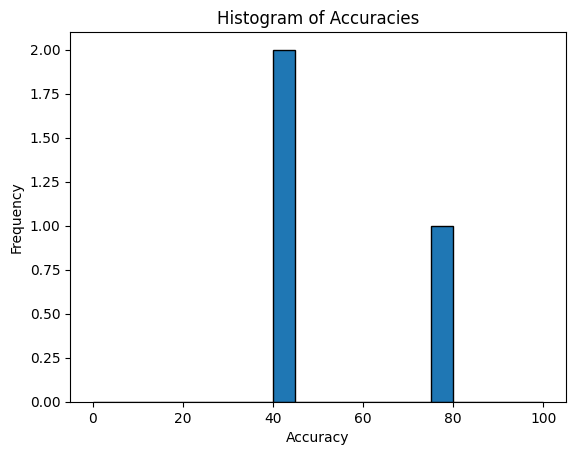

In [19]:
fig = hist_accuracies(df["Accuracy"])

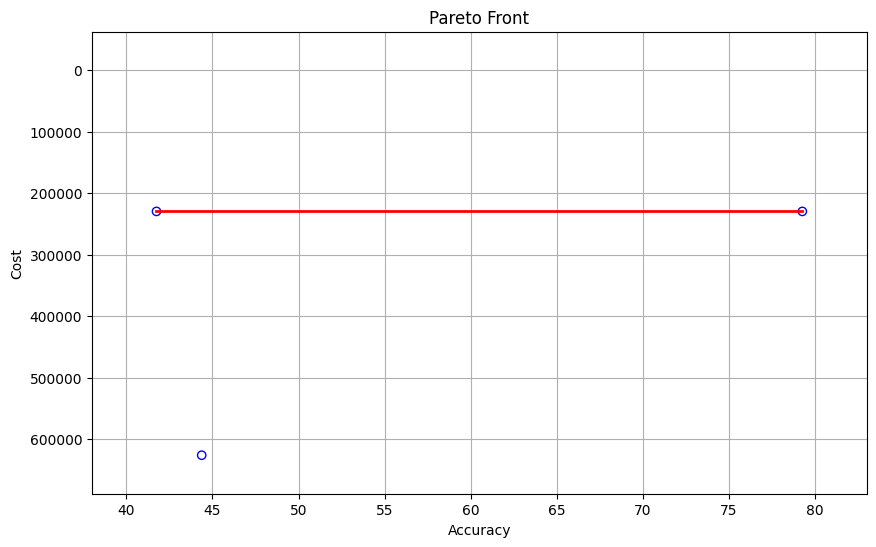

In [20]:
from src.nas import plot

plot.plot_pareto_front(df["Accuracy"], df["Complexity"])